# Handheld VESAD - Data visualization and analysis

## Load and prepare the data

### Configuration

In [249]:
import numpy as np
import pandas as pd
import seaborn as sns

from pandas.api.types import CategoricalDtype
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from statsmodels import api as sm

from ast import literal_eval
from os import listdir
from os.path import join

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')

### Load the csv data files

The participants information are in `participants`, all the trials in `trials`, and the detailled mesures of the trials in `trial_details`.

In [126]:
participants = pd.read_csv('participants.csv')
trials = pd.read_csv('participants_trials.csv')

# Detailled trials are long to load, keep commented if unused
#trial_details = []
#for file in listdir('.'):
#    if file.endswith('details.csv'): # The trial files end with *-details.csv
#        details.append(pd.read_csv(file))
#trial_details = pd.concat(details, ignore_index=True)

### Reshape the data to be more useful

Creates `participants_ivs`, `trials_ivs` independent variables lists, and `participants_dps`, `trials_dps` dependent variables list from participants and trials. Used to set up categories on some variables and to set a displaying name on all of them.

In [151]:
# Sets up independent variables lists
participants_iv_labels = participants.loc[:, 'participant_id':'hmd_interactions'].columns
participants_iv_names = ['Participant Id', 'Sex', 'Has Glasses', 'Has Contact Lenses', 'Is Color Blind',\
                         'Age Class', 'Dominant Hand', 'Hand Used for Mouse', 'Activity', 'Computer Hours per Day',\
                         '3D Softwares Used', 'HMD Used', 'Known Interactions Techniques on HMD']
participants_ivs = pd.DataFrame(data=[participants_iv_labels, participants_iv_names],\
                                columns=participants_iv_labels, index=['label', 'name'])

trials_iv_labels = ['technique', 'text_size', 'distance']
trials_iv_names = ['Technique', 'Text Size', 'Distance']
trials_ivs = pd.DataFrame(columns=trials_iv_labels, index=['label', 'name', 'categorical'])

for i in range(len(trials_ivs.columns)):
    iv_label = trials_ivs.columns[i]
    iv_id = iv_label + '_id'
    iv_categories = trials.drop_duplicates(iv_id).loc[:, [iv_id, iv_label]].sort_values([iv_id])
    trials[iv_id] = trials[iv_id].astype(CategoricalDtype(categories=iv_categories[iv_id], ordered=True))
    trials[iv_label] = trials[iv_label].astype(CategoricalDtype(categories=iv_categories[iv_label], ordered=True))
    trials_ivs[iv_label] = [trials_iv_labels[i], trials_iv_names[i],\
                            pd.Categorical(iv_categories[iv_label], iv_categories[iv_label], ordered=True)]

ordering_categories = participants.drop_duplicates('ordering').loc[:, ['ordering']].sort_values(['ordering'])['ordering']
trials_ivs['ordering'] = ['ordering', 'Ordering',\
                          pd.Categorical(ordering_categories, ordering_categories, ordered=True)]

technique_categories = trials_ivs['technique']['categorical'].categories
text_size_categories = trials_ivs['text_size']['categorical'].categories
distance_categories = trials_ivs['distance']['categorical'].categories
ordering_categories = trials_ivs['ordering']['categorical'].categories

In [161]:
# Sets up dependent variables lists
participants_dv_labels = participants.loc[:, 'easy_understand':'frustration'].columns
participants_dv_names = ['Easy to Understand', 'Mentally Easy to Use', 'Physically Easy to Use',\
                         'Subjective Speed', 'Subjective Performance', 'Frustration']
participants_dv_scale = pd.Categorical(list(range(1,6)), list(range(1,6)), ordered=True)
participants_dv_palette = sns.color_palette('RdYlBu', 5)
participants_dvs = pd.DataFrame(data=[participants_dv_labels, participants_dv_names,\
                                      [participants_dv_scale] * len(participants_dv_labels),\
                                      [participants_dv_palette] * len(participants_dv_labels)],\
                                columns=participants_dv_labels, index=['label', 'name', 'scale', 'palette'])

participants_dvs['preference'] = ['preference', 'Preference',\
                                  pd.Categorical(list(range(1,4)), list(range(1,4)), ordered=True),\
                                  [sns.color_palette('RdYlBu', 5)[i] for i in range(4,-1,-2)]]

trials_dv_labels = trials.loc[:, 'total_time':'signed_head_phone_distance'].columns
trials_dv_names = ['Completion Time (s)', 'Selections', 'Total Time Selecting (s)', 'Total Distance Selecting (m)',\
                   'Total Distance Projected on Grid Selecting (m)', 'Deselections', 'Errors', 'Items Classified',\
                   'Number of Pans', 'Total Time Panning (s)', 'Total Distance Panning (m)',\
                   'Total Distance Projected on Grid Panning (m)', 'Number of Zooms', 'Total Time Zooming (s)',\
                   'Total Distance Zooming (m)', 'Total Distance Projected on Grid Zooming (m)',\
                   'Total Head Phone Distance (m)', 'Signed Total Head Phone Distance (m)']
trials_dvs = pd.DataFrame(data=[trials_dv_labels, trials_dv_names],\
                          columns=trials_dv_labels, index=['label', 'name'])

Clean the data:

In [226]:
# Set the participant_id column as the index in participants
participants.set_index('participant_id', inplace=True)

In [129]:
# Some participants are non valid or don't have complete mesures
non_valid_participants = [0]
participants = participants[~participants.index.isin(non_valid_participants)].reset_index()

incomplete_trials_participant_ids = [0, 4]
trials = trials[~trials['participant_id'].isin(incomplete_trials_participant_ids)].reset_index()

# Some participants have wrong head phone mesures
for head_distance_column in ['absolute_head_phone_distance', 'signed_head_phone_distance']:
    trials.loc[trials[head_distance_column] == 0, head_distance_column] = np.nan

In [228]:
# Copy ordering column from participants to trials
trials['ordering'] = [participants.at[participant_id, 'ordering'] for participant_id in trials['participant_id']]

In [176]:
# Eval the arrays in some dvs
def eval_if_str(data):
    return literal_eval(data) if isinstance(data, str) else data

for dv_label in participants_dvs.columns:
    participants[dv_label] = participants[dv_label].apply(eval_if_str)

trials['grid_config'] = trials['grid_config'].apply(eval_if_str)

Creates `participants_rates` (extracted from `participants`):

In [186]:
participants_rates_index = pd.MultiIndex.from_product([participants.index, participants_dvs.columns,\
                                                       range(len(technique_categories))],\
                                                      names=['participant_id', 'dependent_variable', 'technique_id'])

participants_rates = []
for participant_id, dv, technique_id in participants_rates_index:
    participant = participants.loc[participant_id, :]
    participants_rates.append([technique_categories[technique_id]]\
                              + participant[participants_ivs.loc[:, 'sex':'hmd_interactions'].columns].tolist()\
                              + [participant['ordering'], participant[dv][technique_id]])

participants_rates_columns = ['technique'] + participants_ivs.loc[:, 'sex':'hmd_interactions'].columns.tolist()\
                             + ['ordering', 'rate']
participants_rates = pd.DataFrame(participants_rates, index=participants_rates_index, columns=participants_rates_columns)
participants_rates.reset_index(inplace=True)

# Restore the categorical IV columns (necessary to maintain the conditions order)
for iv in ['ordering', 'technique']:
    participants_rates[iv] = participants_rates[iv].astype(CategoricalDtype(categories=trials_ivs[iv]['categorical'], ordered=True), copy=False)

Utilities:

In [9]:
participants_dvs_barplot_palette = sns.color_palette('Set2')

## Visualizations of the participants rates and preferences

In [188]:
def get_participants_rates_count(iv_labels, dv_label):
    rates_counts = participants_rates[participants_rates['dependent_variable'] == dv_label]
    rates_counts = rates_counts.groupby(iv_labels + ['rate']).size() # Gets the counts
    
    ivs = [trials_ivs[iv_label]['categorical'] for iv_label in iv_labels]
    rates_counts_index = pd.MultiIndex.from_product(ivs + [participants_dvs.at['scale', dv_label]],\
                                                    names=iv_labels + ['rate'])
    zero_rates_counts = pd.Series(0, index=rates_counts_index)
    
    rates_counts = pd.concat([rates_counts, zero_rates_counts]) # Merge counts with the default counts
    rates_counts = rates_counts[~rates_counts.index.duplicated(keep='first')] # Keeps the counts or the default counts
    rates_counts.sort_index(inplace=True)
    rates_counts.index = rates_counts_index # Restore the index
    return rates_counts

In [11]:
def cumulated_barplot(data, palette, **args):
    for row_index, row in data.iloc[::-1].iterrows():
        sns.barplot(x=row, y=row.index, label=row_index, color=palette[row_index-1], orient='h', **args)

In [194]:
def plot_participants_rates(dv_label):
    iv_technique, iv_ordering = trials_ivs['technique'], trials_ivs['ordering']
    dv = participants_dvs[dv_label]
    rates = participants_rates[participants_rates['dependent_variable'] == dv_label]
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

    cumulated_rates_count = get_participants_rates_count(['technique'], dv_label).unstack(level=0).cumsum()
    cumulated_barplot(cumulated_rates_count, palette=dv['palette'], ax=axs[0])
    axs[0].set(xlabel='Number of participants', ylabel=iv_technique['name'])
    axs[0].legend(title='Rates', frameon=True)
    
    sns.barplot(x=iv_technique['label'], y='rate', data=rates, palette=participants_dvs_barplot_palette, ax=axs[1])
    axs[1].set(xlabel=iv_technique['name'], ylabel=dv['name'], ylim=(0, dv['scale'][-1]))
    
    sns.barplot(x=iv_ordering['label'], y='rate', hue=iv_technique['label'], data=rates, palette=participants_dvs_barplot_palette, ax=axs[2])
    axs[2].set(xlabel=iv_ordering['name'], ylabel=dv['name'], ylim=(0, dv['scale'][-1]))
    axs[2].legend(title=iv_technique['name'], frameon=True)

Vizualise, for each 5-points Likert question (5 is the best, 1 is the worst) and for each technique, all the participant rates first, the the mean rate, finally the mean rate dependending of the participant ordering.

Participants tested the techniques in the order:

- (*PhoneOnly*, *PhoneInArOut*, *LeapInArOut*) with ordering 0,
- (*PhoneInArOut*, *LeapInArOut*, *PhoneOnly*) with ordering 1,
- (*LeapInArOut*, *PhoneOnly*, *PhoneInArOut*) with ordering 2.

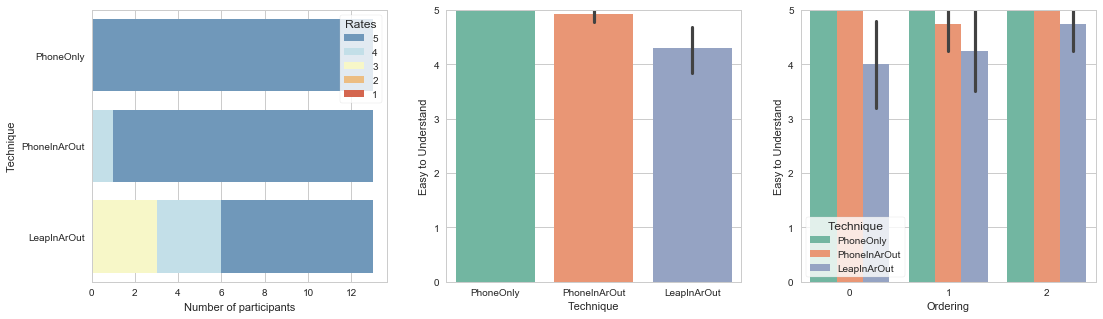

In [195]:
plot_participants_rates('easy_understand')

*LeapInArOut* is harder to understand than the others techniques, particularly when it's the last technique tested (ordering 0). I hypothesised the same, because it presents new interaction techniques.

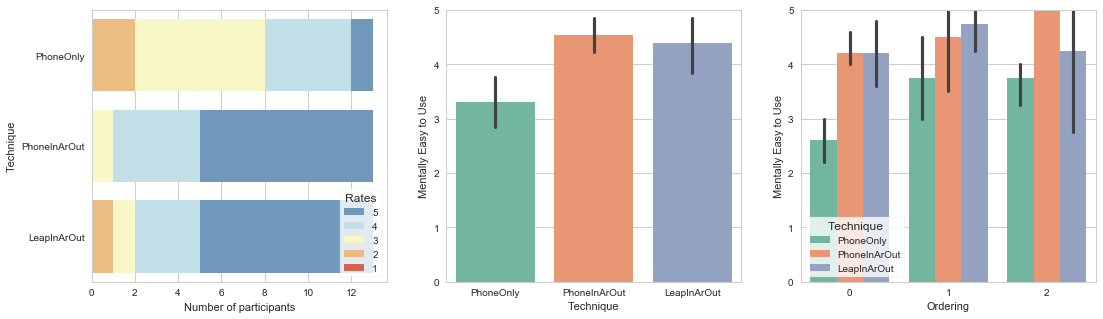

In [133]:
plot_participants_rates('mentally_easy_use')

*PhoneOnly* is mentally more difficult to use mentally than the other techniques, particularly when it's the first technique tested (ordering 0). I hypothesised *PhoneInArOut* to be the easiest to use mentally as the screen is larger and the interaction techniques used are already mastered by the participants.

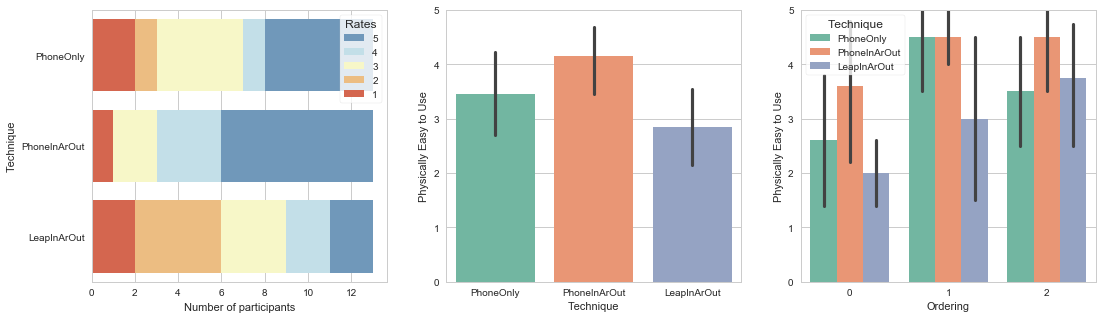

In [134]:
plot_participants_rates('physically_easy_use')

TECHNIQUE has no effect on PHYSICALLY_EASY_USE. I hypothesised *PhoneInArOut* to be the less tiring. But some participants told me that even if the screen is bigger, it demands to pan very often to reach a target (an item or a grid's cell). The same applies to *PhoneOnly*. *LeapInArOut* is also tiring, because the mid-air interactions cause arm fatigue. However, some participants liked the ability to reach directly a target outside the phone's screen.

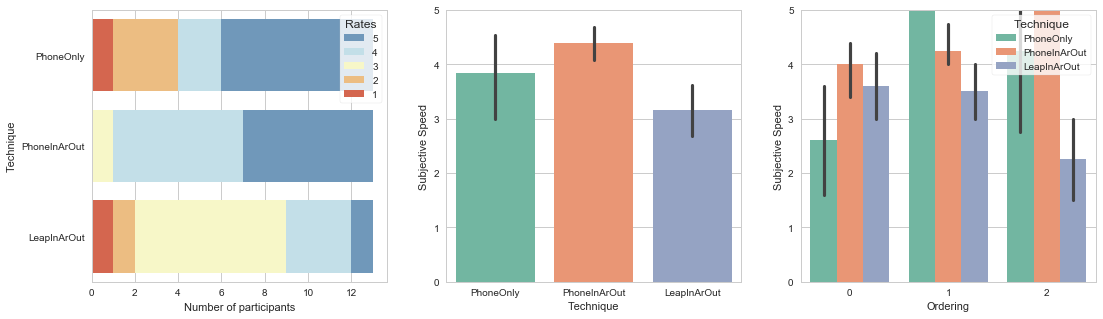

In [135]:
plot_participants_rates('could_go_fast')

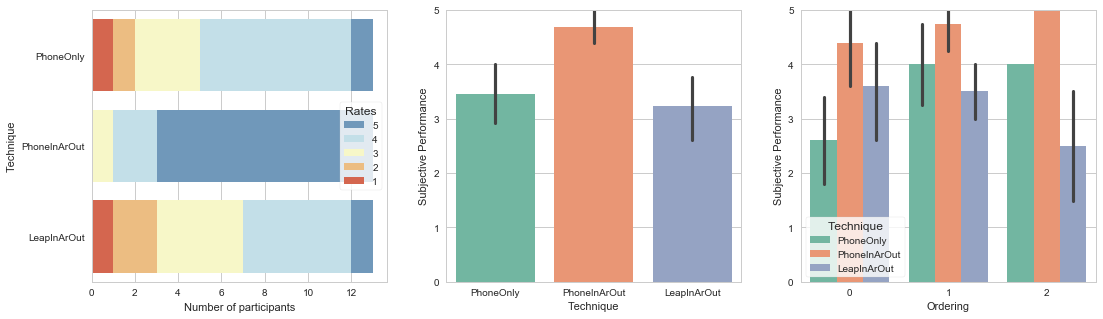

In [136]:
plot_participants_rates('subjective_performance')

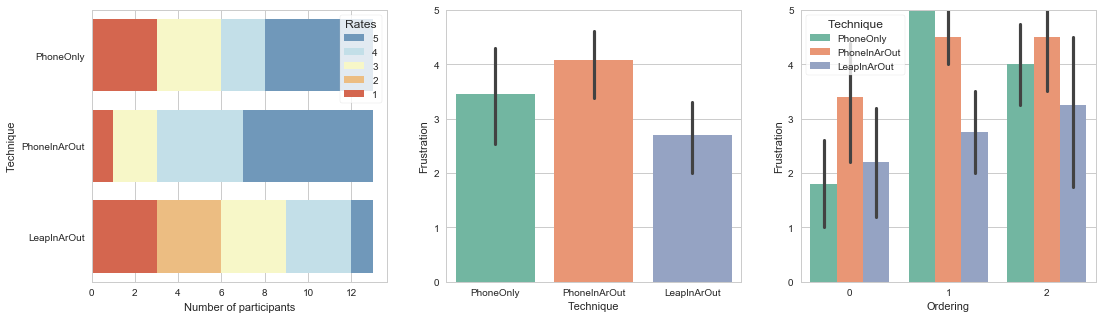

In [137]:
plot_participants_rates('frustration')

Visualize the participants preferences (1 is better, 3 is worst):

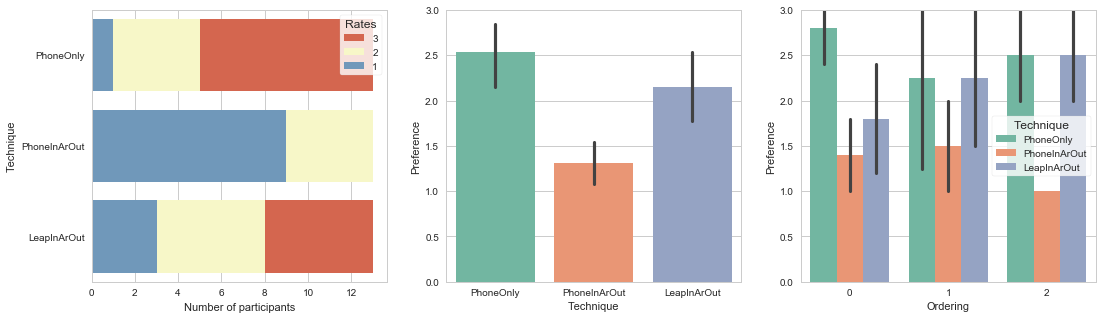

In [192]:
plot_participants_rates('preference')

## Visualizations of the trials

### Distributions

Visualize the distributions of the trial dependent variables to see if there is outliers. There is a row for each DP, with the technique means at the left and the participant boxplots at the right. The have the same y axis scale.

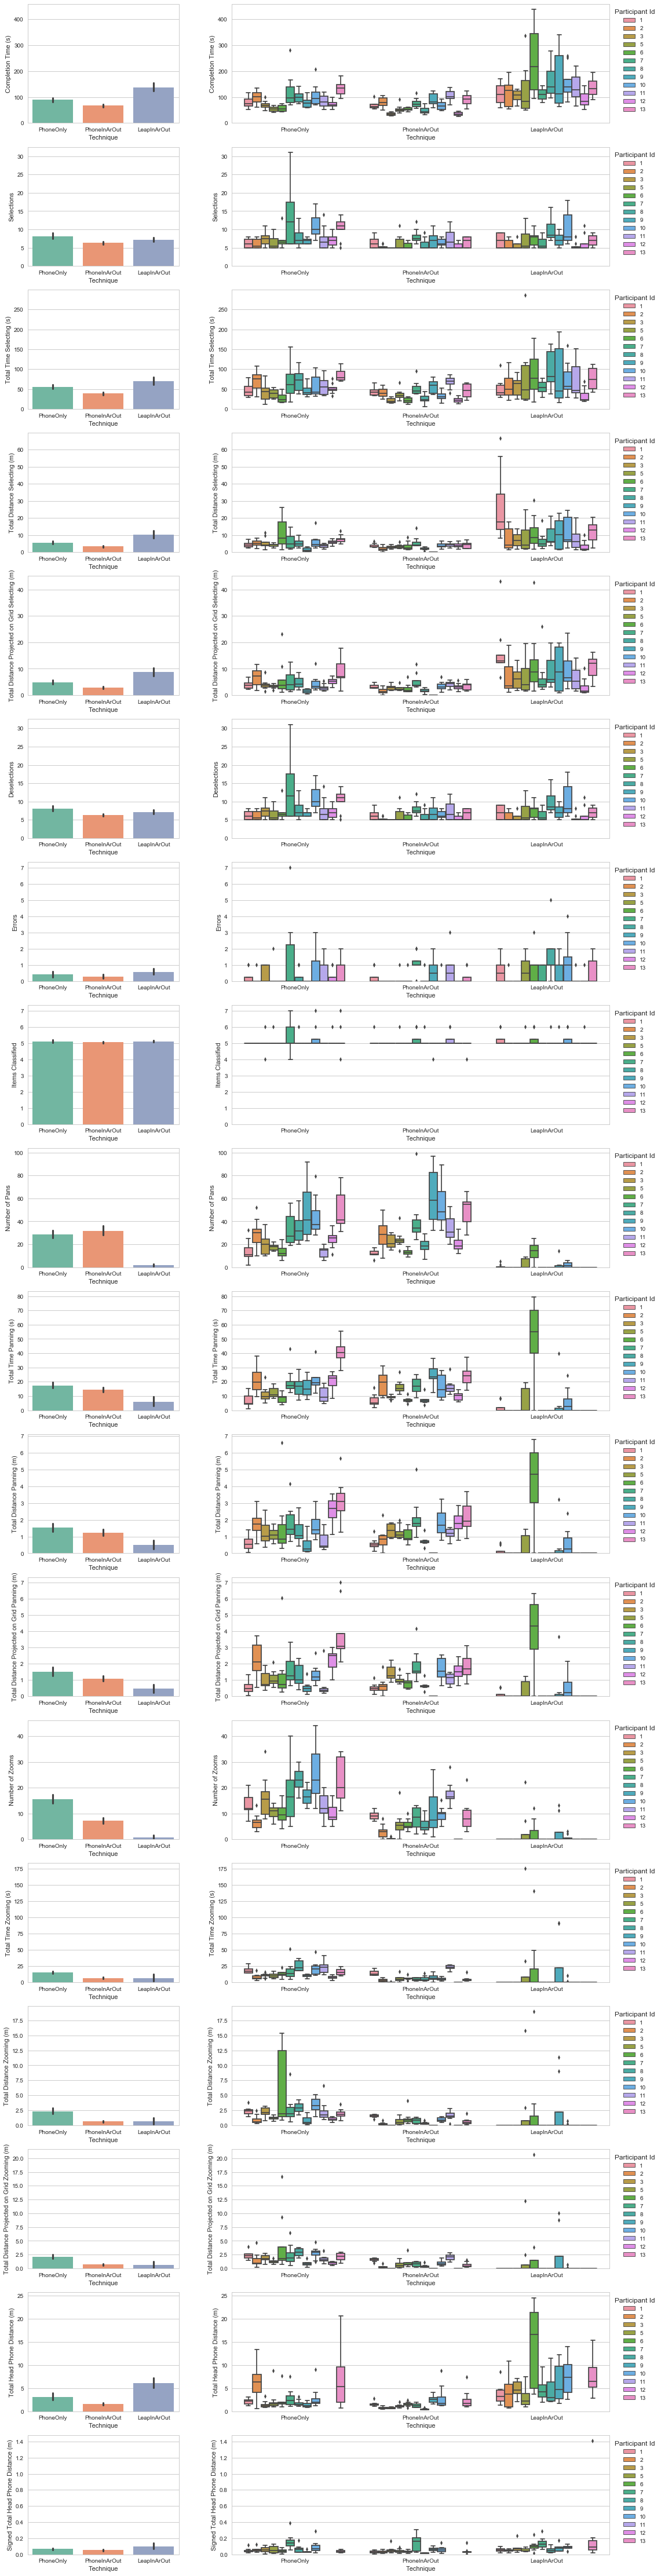

In [213]:
fig = plt.figure(figsize=(18, 4.5 * len(trials_dvs.columns)))
gs = gridspec.GridSpec(nrows=len(trials_dvs.columns), ncols=2, width_ratios=[1, 2.5])

for row in range(len(trials_dvs.columns)):
    iv, dv = trials_ivs['technique'], trials_dvs.iloc[:, row]
    
    ax1 = plt.subplot(gs[2 * row])
    sns.barplot(x=iv['label'], y=dv['label'], data=trials, palette=participants_dvs_barplot_palette, ax=ax1)
    ax1.set(xlabel=iv['name'], ylabel=dv['name'], ylim=(0, None))

    ax2 = plt.subplot(gs[2 * row + 1], sharey=ax1)
    sns.boxplot(x=iv['label'], y=dv['label'], hue='participant_id', data=trials, ax=ax2)
    ax2.set(xlabel=iv['name'], ylabel=dv['name'], ylim=(0, None))
    ax2.legend(title=participants_ivs['participant_id']['name'], loc='upper left', bbox_to_anchor=(1, 1))

Visualize the mean completion time and the mean errors:

In [237]:
def plot_trials(iv_label, dv_label):
    iv, iv_ordering, dv = trials_ivs[iv_label], trials_ivs['ordering'], trials_dvs[dv_label]
    
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(12,5))

    sns.barplot(x=iv['label'], y=dv['label'], data=trials, palette=participants_dvs_barplot_palette, ax=axs[0])
    axs[0].set(xlabel=iv['name'], ylabel=dv['name'])

    sns.barplot(x=iv_ordering['label'], y=dv['label'], hue=iv['label'], data=trials, palette=participants_dvs_barplot_palette, ax=axs[1])
    axs[1].set(xlabel=iv_ordering['name'], ylabel=dv['name'])
    axs[1].legend(title=iv['name'], frameon=True)

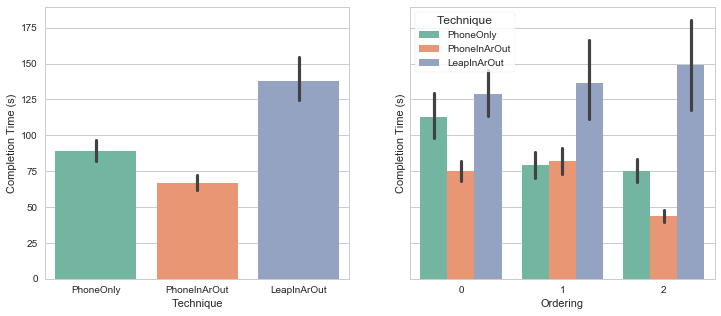

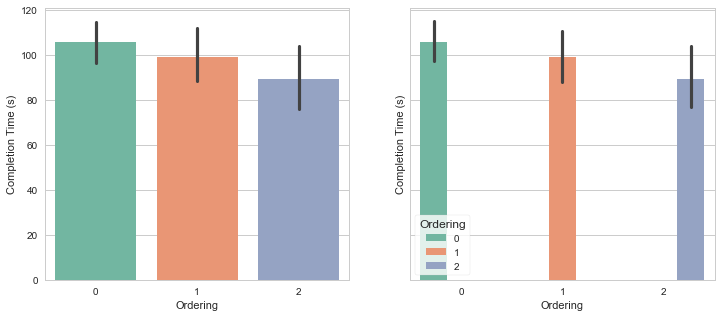

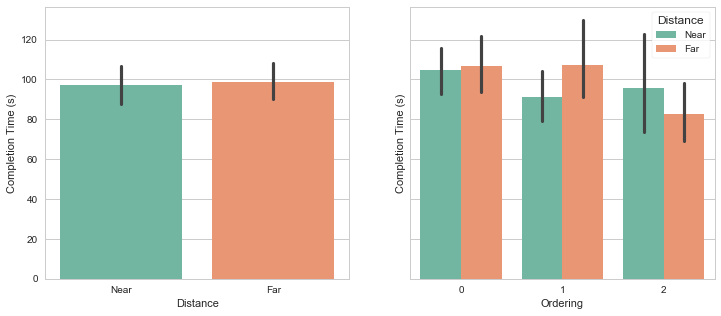

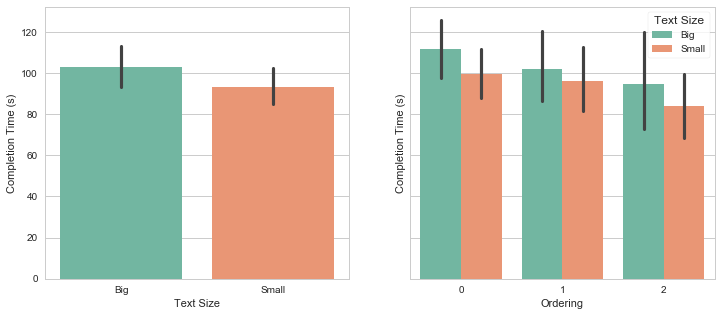

In [242]:
plot_trials('technique', 'total_time')
plot_trials('distance', 'total_time')
plot_trials('text_size', 'total_time')

In [250]:
sm.stats.anova_lm(ols('total_time ~ technique', data=trials).fit(), typ=2)

,sum_sq,df,F,PR(>F)
technique,255563.540640,2.0,47.780852,1.249048e-18
Residual,764858.400081,286.0,NaN,NaN


*PhoneInArOut* is the fastest to complete and *LeapInArOut* the longest, like I hypothesised.

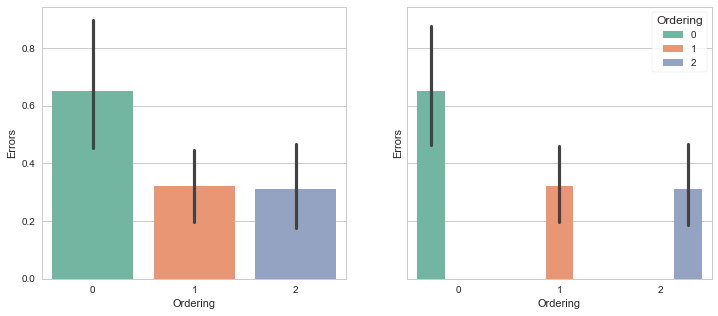

In [241]:
plot_trials('technique', 'errors')
plot_trials('distance', 'errors')
plot_trials('text_size', 'errors')

None of TECHNIQUE, DISTANCE or TEXT_SIZE have an effect on ERRORS.

## Bonus

Visualize the distribution of the items to classify:

In [ ]:
grid_shape, grid_items_count = (5, 3), 5

def countGridItemsToClassify(participant_ids):
    grid_counts = pd.DataFrame(0, columns=range(grid_cols), index=range(grid_rows))
    for index, grid_config in trials.loc[trials['participant_id'].isin(participant_ids), 'grid_config'].iteritems():
        for i in range(grid_shape[1]):
            for j in range(grid_shape[0]):
                if grid_config[i][j][0] == grid_config[i][j][grid_items_count - 1]:
                    grid_counts.iat[i, j] = grid_counts.iat[i, j] + 1
    return grid_counts

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,3))

sns.heatmap(countGridItemsToClassify(participants.index.tolist()), vmin=0, annot=True, fmt='d', cmap='YlGnBu', ax=axs[0])
axs[0].set(title='Occurence of items on the grid to classify | all participants')

for i in range(len(ordering)):
    grid_counts = countGridItemsToClassify(participants[participants['ordering'] == ordering[i]]['participant_id'].tolist())
    sns.heatmap(grid_counts, vmin=0, annot=True, fmt='d', cmap='YlGnBu', ax=axs[i+1])
    axs[i+1].set(title='Occurence of items on the grid to classify | ordering ' + str(ordering[i]))